In [14]:
!pip install qutip --quiet

In [15]:
!pip install quocs-lib

In [16]:
%%writefile opt_dictionary.json
{
  "optimization_client_name": "HybridNV_Resonator_dCRAB",
  "optimization_direction": "minimization",

  "algorithm_settings": {
    "algorithm_name": "dCRAB",
    "super_iteration_number": 4,
    "max_eval_total": 300,
    "dsm_settings": {
      "general_settings": {
        "dsm_algorithm_name": "NelderMead",
        "is_adaptive": true
      },
      "stopping_criteria": {
        "xatol": 1e-3,
        "fatol": 1e-3
      }
    }
  },

  "pulses": [
    {
      "pulse_name": "drive",
      "upper_limit": 1.5,
      "lower_limit": -1.5,
      "bins_number": 150,
      "time_name": "t",
      "basis": {
        "basis_name": "Fourier",
        "basis_vector_number": 4,
        "random_super_parameter_distribution": {
          "distribution_name": "Uniform",
          "lower_limit": 0.1,
          "upper_limit": 5.0
        }
      },
      "initial_guess": {
        "function_type": "lambda_function",
        "lambda_function": "lambda t: 0.3*np.sin(2*np.pi*t/200.0)"
      }
    }
  ],

  "parameters": [],

  "times": [
    {
      "time_name": "t",
      "initial_value": 200.0
    }
  ]
}


Overwriting opt_dictionary.json


In [17]:
%%writefile fom_hybrid.py
import numpy as np
import qutip as qt
from quocslib.utils.AbstractFoM import AbstractFoM


# 1. UNIT CONVERSION

two_pi = 2*np.pi

def MHz_to_radns(MHz):
    return two_pi * MHz * 1e-3

def per_us_to_per_ns(rate):
    return rate * 1e-3



omega_a  = MHz_to_radns(2000.0)
omega_b  = MHz_to_radns(2000.0)
omega_eg = MHz_to_radns(2000.0)

omega_ge1 = MHz_to_radns(2000.0)
omega_ge2 = MHz_to_radns(2000.0)

omega_gu1 = MHz_to_radns(2800.0)
omega_gu2 = MHz_to_radns(2800.0)

g_a = MHz_to_radns(260.0)
g_b = MHz_to_radns(260.0)
g1  = MHz_to_radns(7.0)
g2  = MHz_to_radns(7.0)

# Detuning
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg
delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2

# Collapse rates
kappa     = per_us_to_per_ns(1/20)
gamma_q   = per_us_to_per_ns(1/20)
gamma_phi = per_us_to_per_ns(1/200)


# 2. STATIC OPERATORS
def tensor_op(*ops):
    return qt.tensor(*ops)

# Resonators
a = tensor_op(qt.destroy(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
b = tensor_op(qt.qeye(2), qt.destroy(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))

# Qubit operators
sigma_plus  = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmap(), qt.qeye(3), qt.qeye(3))
sigma_minus = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmam(), qt.qeye(3), qt.qeye(3))

# NV operators
def S_op(level, i, j, idx):
    ops = [qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(level), qt.qeye(level)]
    ops[idx] = qt.basis(level, i) * qt.basis(level, j).dag()
    return tensor_op(*ops)

S1_ge_plus  = S_op(3,1,0,3)
S1_ge_minus = S_op(3,0,1,3)
S1_gu_plus  = S_op(3,2,0,3)
S1_gu_minus = S_op(3,0,2,3)

S2_ge_plus  = S_op(3,1,0,4)
S2_ge_minus = S_op(3,0,1,4)
S2_gu_plus  = S_op(3,2,0,4)
S2_gu_minus = S_op(3,0,2,4)

# Collapse operators
c_ops_static = [
    np.sqrt(kappa) * a,
    np.sqrt(kappa) * b,
    np.sqrt(gamma_q) * sigma_minus,
    np.sqrt(gamma_phi) * (sigma_plus * sigma_minus)
]

# Initial state
psi0 = tensor_op(
    qt.basis(2,0), qt.basis(2,0), qt.basis(2,0),
    qt.basis(3,0), qt.basis(3,0)
)


# 3. TARGET STATE ρ_T4 (ENTANGLED + WHITE NOISE)
λ = 0.90
g1q = qt.basis(3,0); e1q = qt.basis(3,1)
g2q = qt.basis(3,0); e2q = qt.basis(3,1)

NV_gg = qt.tensor(g1q, g2q)
NV_ee = qt.tensor(e1q, e2q)
NV_ge = qt.tensor(g1q, e2q)
NV_eg = qt.tensor(e1q, g2q)

rho_white_NV = (NV_gg*NV_gg.dag() + NV_ge*NV_ge.dag() +
                 NV_eg*NV_eg.dag() + NV_ee*NV_ee.dag()) / 4.0

NV_ent = (NV_gg + NV_ee).unit()
rho_T3_NV = NV_ent * NV_ent.dag()

proj_a = qt.basis(2,0) * qt.basis(2,0).dag()
proj_b = qt.basis(2,0) * qt.basis(2,0).dag()
proj_q = qt.basis(2,0) * qt.basis(2,0).dag()

rho_T3 = qt.tensor(proj_a, proj_b, proj_q, rho_T3_NV)
rho_T4 = λ * rho_T3 + (1-λ)*qt.tensor(proj_a, proj_b, proj_q, rho_white_NV)


# 4. HYBRID FoM CLASS UNTUK QUOCS
class HybridFoM(AbstractFoM):

    def __init__(self, args_dict=None):
        self.psi0 = psi0
        self.rho_target = rho_T4
        self.c_ops = c_ops_static

        # physics constants
        self.g_a = g_a; self.g_b = g_b; self.g1 = g1; self.g2 = g2
        self.da = delta_a; self.db = delta_b
        self.d1ge = delta1_ge; self.d1gu = delta1_gu
        self.d2ge = delta2_ge; self.d2gu = delta2_gu

        # operator references
        self._ops = [
            (g_a * a * sigma_plus,        self.da,  +1),
            (g_a * a.dag() * sigma_minus, self.da,  -1),
            (g_b * b * sigma_plus,        self.db,  +1),
            (g_b * b.dag() * sigma_minus, self.db,  -1),

            (g1 * a * S1_ge_plus,         self.d1ge, +1),
            (g1 * a.dag()*S1_ge_minus,    self.d1ge, -1),
            (g1 * a * S1_gu_plus,         self.d1gu, +1),
            (g1 * a.dag()*S1_gu_minus,    self.d1gu, -1),

            (g2 * b * S2_ge_plus,         self.d2ge, +1),
            (g2 * b.dag()*S2_ge_minus,    self.d2ge, -1),
            (g2 * b * S2_gu_plus,         self.d2gu, +1),
            (g2 * b.dag()*S2_gu_minus,    self.d2gu, -1),
        ]

        self.n_points = args_dict.get("n_points", 1500) if args_dict else 1500


    # MAIN: Compute FoM
    def get_FoM(self, pulses=[], parameters=[], timegrids=[]):

        pulse = np.array(pulses[0])
        tgrid = np.array(timegrids[0])
        T = tgrid[-1]

        # build fine grid for QuTiP
        times = np.linspace(0, T, self.n_points)
        pulse_interp = np.interp(times, tgrid, pulse)

        # Build H(t) as list of [operator, coeff_array]
        H_t = []

        # all coupling operators
        for (op, det, sgn) in self._ops:
            H_t.append([op, np.exp(1j * sgn * det * times)])

        # drive terms
        H_t.append([a,      pulse_interp * np.exp(1j*self.da*times)])
        H_t.append([a.dag(), np.conj(pulse_interp * np.exp(1j*self.da*times))])
        H_t.append([b,      pulse_interp * np.exp(1j*self.db*times)])
        H_t.append([b.dag(), np.conj(pulse_interp * np.exp(1j*self.db*times))])

        opts = qt.Options(nsteps=5000)

        try:
            result = qt.mesolve(H_t, self.psi0, times, self.c_ops, [], options=opts)
        except Exception as e:
            print("mesolve error:", e)
            return {"FoM": 1.0}

        rho_final = result.states[-1]
        F = qt.fidelity(rho_final, self.rho_target)
        return {"FoM": 1.0 - float(np.real(F))}


Overwriting fom_hybrid.py


In [18]:
from fom_hybrid import HybridFoM
fom = HybridFoM(args_dict={"n_points":2000})


In [19]:
from quocslib.utils.inputoutput import readjson
from quocslib.Optimizer import Optimizer

opt_dict = readjson("opt_dictionary.json")
optimizer = Optimizer(opt_dict, fom)
optimizer.execute()


INFO     oc_logger    The optimization direction is minimization


INFO:oc_logger:The optimization direction is minimization


INFO     oc_logger    QuOCS version number: 0.0.66


INFO:oc_logger:QuOCS version number: 0.0.66


INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.6670917210269606


INFO:oc_logger:New record achieved. Previous FoM: 10000000000, new best FoM : 0.6670917210269606


INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.6670917210269606


INFO:oc_logger:Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.6670917210269606


INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.790306952543277


INFO:oc_logger:Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.790306952543277


INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.7972562508113472


INFO:oc_logger:Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.7972562508113472


INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.8567137261536844


INFO:oc_logger:Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.8567137261536844


INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.8110194824739904


INFO:oc_logger:Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.8110194824739904


INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.9631259145439459


INFO:oc_logger:Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.9631259145439459


INFO     oc_logger    Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.8185640068017145


INFO:oc_logger:Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.8185640068017145


INFO     oc_logger    Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.9014037005364673


INFO:oc_logger:Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.9014037005364673


INFO     oc_logger    Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.7978399826305582


INFO:oc_logger:Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.7978399826305582


INFO     oc_logger    Function evaluation number: 10, SI: 1, Sub-iteration number: 1, FoM: 0.9149005051306754


INFO:oc_logger:Function evaluation number: 10, SI: 1, Sub-iteration number: 1, FoM: 0.9149005051306754


INFO     oc_logger    Function evaluation number: 11, SI: 1, Sub-iteration number: 1, FoM: 0.9579632492141944


INFO:oc_logger:Function evaluation number: 11, SI: 1, Sub-iteration number: 1, FoM: 0.9579632492141944


INFO     oc_logger    Function evaluation number: 12, SI: 1, Sub-iteration number: 1, FoM: 0.8550510466921435


INFO:oc_logger:Function evaluation number: 12, SI: 1, Sub-iteration number: 1, FoM: 0.8550510466921435


INFO     oc_logger    Function evaluation number: 13, SI: 1, Sub-iteration number: 1, FoM: 0.8739975613756674


INFO:oc_logger:Function evaluation number: 13, SI: 1, Sub-iteration number: 1, FoM: 0.8739975613756674


INFO     oc_logger    Function evaluation number: 14, SI: 1, Sub-iteration number: 1, FoM: 0.9029398271096342


INFO:oc_logger:Function evaluation number: 14, SI: 1, Sub-iteration number: 1, FoM: 0.9029398271096342


INFO     oc_logger    Function evaluation number: 15, SI: 1, Sub-iteration number: 1, FoM: 0.9047060993659205


INFO:oc_logger:Function evaluation number: 15, SI: 1, Sub-iteration number: 1, FoM: 0.9047060993659205


INFO     oc_logger    Function evaluation number: 16, SI: 1, Sub-iteration number: 1, FoM: 0.8103641226888267


INFO:oc_logger:Function evaluation number: 16, SI: 1, Sub-iteration number: 1, FoM: 0.8103641226888267


INFO     oc_logger    Function evaluation number: 17, SI: 1, Sub-iteration number: 1, FoM: 0.8558127779513647


INFO:oc_logger:Function evaluation number: 17, SI: 1, Sub-iteration number: 1, FoM: 0.8558127779513647


INFO     oc_logger    Function evaluation number: 18, SI: 1, Sub-iteration number: 1, FoM: 0.8550495550443755


INFO:oc_logger:Function evaluation number: 18, SI: 1, Sub-iteration number: 1, FoM: 0.8550495550443755


INFO     oc_logger    Function evaluation number: 19, SI: 1, Sub-iteration number: 1, FoM: 0.847008072037503


INFO:oc_logger:Function evaluation number: 19, SI: 1, Sub-iteration number: 1, FoM: 0.847008072037503


INFO     oc_logger    Function evaluation number: 20, SI: 1, Sub-iteration number: 2, FoM: 0.749273356284065


INFO:oc_logger:Function evaluation number: 20, SI: 1, Sub-iteration number: 2, FoM: 0.749273356284065


INFO     oc_logger    Function evaluation number: 21, SI: 1, Sub-iteration number: 3, FoM: 0.8741260137191194


INFO:oc_logger:Function evaluation number: 21, SI: 1, Sub-iteration number: 3, FoM: 0.8741260137191194


INFO     oc_logger    Function evaluation number: 22, SI: 1, Sub-iteration number: 3, FoM: 0.7386494358493925


INFO:oc_logger:Function evaluation number: 22, SI: 1, Sub-iteration number: 3, FoM: 0.7386494358493925


INFO     oc_logger    Function evaluation number: 23, SI: 1, Sub-iteration number: 4, FoM: 0.8760591277719985


INFO:oc_logger:Function evaluation number: 23, SI: 1, Sub-iteration number: 4, FoM: 0.8760591277719985


INFO     oc_logger    New record achieved. Previous FoM: 0.6670917210269606, new best FoM : 0.5986653464701042


INFO:oc_logger:New record achieved. Previous FoM: 0.6670917210269606, new best FoM : 0.5986653464701042


INFO     oc_logger    Function evaluation number: 24, SI: 1, Sub-iteration number: 4, FoM: 0.5986653464701042


INFO:oc_logger:Function evaluation number: 24, SI: 1, Sub-iteration number: 4, FoM: 0.5986653464701042


INFO     oc_logger    Function evaluation number: 25, SI: 1, Sub-iteration number: 5, FoM: 0.8691386341423119


INFO:oc_logger:Function evaluation number: 25, SI: 1, Sub-iteration number: 5, FoM: 0.8691386341423119


INFO     oc_logger    Function evaluation number: 26, SI: 1, Sub-iteration number: 5, FoM: 0.9144429032523141


INFO:oc_logger:Function evaluation number: 26, SI: 1, Sub-iteration number: 5, FoM: 0.9144429032523141


INFO     oc_logger    Function evaluation number: 27, SI: 1, Sub-iteration number: 5, FoM: 0.6187667933080525


INFO:oc_logger:Function evaluation number: 27, SI: 1, Sub-iteration number: 5, FoM: 0.6187667933080525


INFO     oc_logger    Function evaluation number: 28, SI: 1, Sub-iteration number: 5, FoM: 0.7842270732978283


INFO:oc_logger:Function evaluation number: 28, SI: 1, Sub-iteration number: 5, FoM: 0.7842270732978283


INFO     oc_logger    Function evaluation number: 29, SI: 1, Sub-iteration number: 5, FoM: 0.9341800420750663


INFO:oc_logger:Function evaluation number: 29, SI: 1, Sub-iteration number: 5, FoM: 0.9341800420750663


INFO     oc_logger    Function evaluation number: 30, SI: 1, Sub-iteration number: 5, FoM: 0.6470038405061566


INFO:oc_logger:Function evaluation number: 30, SI: 1, Sub-iteration number: 5, FoM: 0.6470038405061566


INFO     oc_logger    Function evaluation number: 31, SI: 1, Sub-iteration number: 5, FoM: 0.8351807257794486


INFO:oc_logger:Function evaluation number: 31, SI: 1, Sub-iteration number: 5, FoM: 0.8351807257794486


INFO     oc_logger    Function evaluation number: 32, SI: 1, Sub-iteration number: 5, FoM: 0.7639652569572503


INFO:oc_logger:Function evaluation number: 32, SI: 1, Sub-iteration number: 5, FoM: 0.7639652569572503


INFO     oc_logger    Function evaluation number: 33, SI: 1, Sub-iteration number: 5, FoM: 0.946997427821535


INFO:oc_logger:Function evaluation number: 33, SI: 1, Sub-iteration number: 5, FoM: 0.946997427821535


INFO     oc_logger    Function evaluation number: 34, SI: 1, Sub-iteration number: 5, FoM: 0.915885421109844


INFO:oc_logger:Function evaluation number: 34, SI: 1, Sub-iteration number: 5, FoM: 0.915885421109844


INFO     oc_logger    Function evaluation number: 35, SI: 1, Sub-iteration number: 6, FoM: 0.9010008770643186


INFO:oc_logger:Function evaluation number: 35, SI: 1, Sub-iteration number: 6, FoM: 0.9010008770643186


INFO     oc_logger    Function evaluation number: 36, SI: 1, Sub-iteration number: 7, FoM: 0.8329058654029126


INFO:oc_logger:Function evaluation number: 36, SI: 1, Sub-iteration number: 7, FoM: 0.8329058654029126


INFO     oc_logger    Function evaluation number: 37, SI: 1, Sub-iteration number: 8, FoM: 0.6760295404184014


INFO:oc_logger:Function evaluation number: 37, SI: 1, Sub-iteration number: 8, FoM: 0.6760295404184014


INFO     oc_logger    Function evaluation number: 38, SI: 1, Sub-iteration number: 9, FoM: 0.9472957575979495


INFO:oc_logger:Function evaluation number: 38, SI: 1, Sub-iteration number: 9, FoM: 0.9472957575979495


INFO     oc_logger    Function evaluation number: 39, SI: 1, Sub-iteration number: 9, FoM: 0.8702927311098463


INFO:oc_logger:Function evaluation number: 39, SI: 1, Sub-iteration number: 9, FoM: 0.8702927311098463


INFO     oc_logger    Function evaluation number: 40, SI: 1, Sub-iteration number: 10, FoM: 0.75340053135979


INFO:oc_logger:Function evaluation number: 40, SI: 1, Sub-iteration number: 10, FoM: 0.75340053135979


INFO     oc_logger    Function evaluation number: 41, SI: 1, Sub-iteration number: 11, FoM: 0.7777929886089552


INFO:oc_logger:Function evaluation number: 41, SI: 1, Sub-iteration number: 11, FoM: 0.7777929886089552


INFO     oc_logger    Function evaluation number: 42, SI: 1, Sub-iteration number: 12, FoM: 0.8642994969552935


INFO:oc_logger:Function evaluation number: 42, SI: 1, Sub-iteration number: 12, FoM: 0.8642994969552935


INFO     oc_logger    New record achieved. Previous FoM: 0.5986653464701042, new best FoM : 0.5806133836448963


INFO:oc_logger:New record achieved. Previous FoM: 0.5986653464701042, new best FoM : 0.5806133836448963


INFO     oc_logger    Function evaluation number: 43, SI: 1, Sub-iteration number: 12, FoM: 0.5806133836448963


INFO:oc_logger:Function evaluation number: 43, SI: 1, Sub-iteration number: 12, FoM: 0.5806133836448963


INFO     oc_logger    Function evaluation number: 44, SI: 1, Sub-iteration number: 13, FoM: 0.871071901759648


INFO:oc_logger:Function evaluation number: 44, SI: 1, Sub-iteration number: 13, FoM: 0.871071901759648


INFO     oc_logger    Function evaluation number: 45, SI: 1, Sub-iteration number: 13, FoM: 0.9152746650390979


INFO:oc_logger:Function evaluation number: 45, SI: 1, Sub-iteration number: 13, FoM: 0.9152746650390979


INFO     oc_logger    Function evaluation number: 46, SI: 1, Sub-iteration number: 13, FoM: 0.8206275995743225


INFO:oc_logger:Function evaluation number: 46, SI: 1, Sub-iteration number: 13, FoM: 0.8206275995743225


INFO     oc_logger    Function evaluation number: 47, SI: 1, Sub-iteration number: 13, FoM: 0.6934466214866115


INFO:oc_logger:Function evaluation number: 47, SI: 1, Sub-iteration number: 13, FoM: 0.6934466214866115


INFO     oc_logger    Function evaluation number: 48, SI: 1, Sub-iteration number: 13, FoM: 0.9317952078411248


INFO:oc_logger:Function evaluation number: 48, SI: 1, Sub-iteration number: 13, FoM: 0.9317952078411248


INFO     oc_logger    Function evaluation number: 49, SI: 1, Sub-iteration number: 13, FoM: 0.6740302205781659


INFO:oc_logger:Function evaluation number: 49, SI: 1, Sub-iteration number: 13, FoM: 0.6740302205781659


INFO     oc_logger    Function evaluation number: 50, SI: 1, Sub-iteration number: 13, FoM: 0.7334021203460759


INFO:oc_logger:Function evaluation number: 50, SI: 1, Sub-iteration number: 13, FoM: 0.7334021203460759


INFO     oc_logger    New record achieved. Previous FoM: 0.5806133836448963, new best FoM : 0.3618991349505034


INFO:oc_logger:New record achieved. Previous FoM: 0.5806133836448963, new best FoM : 0.3618991349505034


INFO     oc_logger    Function evaluation number: 51, SI: 1, Sub-iteration number: 13, FoM: 0.3618991349505034


INFO:oc_logger:Function evaluation number: 51, SI: 1, Sub-iteration number: 13, FoM: 0.3618991349505034


INFO     oc_logger    Function evaluation number: 52, SI: 1, Sub-iteration number: 13, FoM: 0.8643854025216258


INFO:oc_logger:Function evaluation number: 52, SI: 1, Sub-iteration number: 13, FoM: 0.8643854025216258


INFO     oc_logger    Function evaluation number: 53, SI: 1, Sub-iteration number: 13, FoM: 0.45543200901502445


INFO:oc_logger:Function evaluation number: 53, SI: 1, Sub-iteration number: 13, FoM: 0.45543200901502445


INFO     oc_logger    Function evaluation number: 54, SI: 1, Sub-iteration number: 14, FoM: 0.8826103565272648


INFO:oc_logger:Function evaluation number: 54, SI: 1, Sub-iteration number: 14, FoM: 0.8826103565272648


INFO     oc_logger    Function evaluation number: 55, SI: 1, Sub-iteration number: 14, FoM: 0.9340203152048842


INFO:oc_logger:Function evaluation number: 55, SI: 1, Sub-iteration number: 14, FoM: 0.9340203152048842


INFO     oc_logger    Function evaluation number: 56, SI: 1, Sub-iteration number: 14, FoM: 0.7238705125113147


INFO:oc_logger:Function evaluation number: 56, SI: 1, Sub-iteration number: 14, FoM: 0.7238705125113147


INFO     oc_logger    Function evaluation number: 57, SI: 1, Sub-iteration number: 14, FoM: 0.9334756170514685


INFO:oc_logger:Function evaluation number: 57, SI: 1, Sub-iteration number: 14, FoM: 0.9334756170514685


INFO     oc_logger    Function evaluation number: 58, SI: 1, Sub-iteration number: 14, FoM: 0.9413752327840048


INFO:oc_logger:Function evaluation number: 58, SI: 1, Sub-iteration number: 14, FoM: 0.9413752327840048


INFO     oc_logger    Function evaluation number: 59, SI: 1, Sub-iteration number: 14, FoM: 0.886962480562604


INFO:oc_logger:Function evaluation number: 59, SI: 1, Sub-iteration number: 14, FoM: 0.886962480562604


INFO     oc_logger    Function evaluation number: 60, SI: 1, Sub-iteration number: 14, FoM: 0.9231796919061054


INFO:oc_logger:Function evaluation number: 60, SI: 1, Sub-iteration number: 14, FoM: 0.9231796919061054


INFO     oc_logger    Function evaluation number: 61, SI: 1, Sub-iteration number: 14, FoM: 0.7252458821968697


INFO:oc_logger:Function evaluation number: 61, SI: 1, Sub-iteration number: 14, FoM: 0.7252458821968697


INFO     oc_logger    Function evaluation number: 62, SI: 1, Sub-iteration number: 14, FoM: 0.799504818357538


INFO:oc_logger:Function evaluation number: 62, SI: 1, Sub-iteration number: 14, FoM: 0.799504818357538


INFO     oc_logger    Function evaluation number: 63, SI: 1, Sub-iteration number: 14, FoM: 0.9560481429928694


INFO:oc_logger:Function evaluation number: 63, SI: 1, Sub-iteration number: 14, FoM: 0.9560481429928694


INFO     oc_logger    Function evaluation number: 64, SI: 1, Sub-iteration number: 15, FoM: 0.9218118814002605


INFO:oc_logger:Function evaluation number: 64, SI: 1, Sub-iteration number: 15, FoM: 0.9218118814002605


INFO     oc_logger    Function evaluation number: 65, SI: 1, Sub-iteration number: 16, FoM: 0.8052409802499468


INFO:oc_logger:Function evaluation number: 65, SI: 1, Sub-iteration number: 16, FoM: 0.8052409802499468


INFO     oc_logger    Function evaluation number: 66, SI: 1, Sub-iteration number: 17, FoM: 0.7146880481322857


INFO:oc_logger:Function evaluation number: 66, SI: 1, Sub-iteration number: 17, FoM: 0.7146880481322857


INFO     oc_logger    Function evaluation number: 67, SI: 1, Sub-iteration number: 18, FoM: 0.8419673197215746


INFO:oc_logger:Function evaluation number: 67, SI: 1, Sub-iteration number: 18, FoM: 0.8419673197215746


INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 19, FoM: 0.794712319146428


INFO:oc_logger:Function evaluation number: 68, SI: 1, Sub-iteration number: 19, FoM: 0.794712319146428


INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 20, FoM: 0.7553312231515088


INFO:oc_logger:Function evaluation number: 69, SI: 1, Sub-iteration number: 20, FoM: 0.7553312231515088


INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 21, FoM: 0.9272145340229171


INFO:oc_logger:Function evaluation number: 70, SI: 1, Sub-iteration number: 21, FoM: 0.9272145340229171


INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 21, FoM: 0.8998049826061694


INFO:oc_logger:Function evaluation number: 71, SI: 1, Sub-iteration number: 21, FoM: 0.8998049826061694


INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 21, FoM: 0.9165234598122469


INFO:oc_logger:Function evaluation number: 72, SI: 1, Sub-iteration number: 21, FoM: 0.9165234598122469


INFO     oc_logger    Function evaluation number: 73, SI: 1, Sub-iteration number: 21, FoM: 0.8846761101450221


INFO:oc_logger:Function evaluation number: 73, SI: 1, Sub-iteration number: 21, FoM: 0.8846761101450221


INFO     oc_logger    Function evaluation number: 74, SI: 1, Sub-iteration number: 21, FoM: 0.9443198121790001


INFO:oc_logger:Function evaluation number: 74, SI: 1, Sub-iteration number: 21, FoM: 0.9443198121790001


INFO     oc_logger    Function evaluation number: 75, SI: 1, Sub-iteration number: 21, FoM: 0.9259489758667175


INFO:oc_logger:Function evaluation number: 75, SI: 1, Sub-iteration number: 21, FoM: 0.9259489758667175


INFO     oc_logger    Function evaluation number: 76, SI: 1, Sub-iteration number: 21, FoM: 0.41819520632350826


INFO:oc_logger:Function evaluation number: 76, SI: 1, Sub-iteration number: 21, FoM: 0.41819520632350826


INFO     oc_logger    Function evaluation number: 77, SI: 1, Sub-iteration number: 21, FoM: 0.8613584942341604


INFO:oc_logger:Function evaluation number: 77, SI: 1, Sub-iteration number: 21, FoM: 0.8613584942341604


INFO     oc_logger    Function evaluation number: 78, SI: 1, Sub-iteration number: 21, FoM: 0.9458911355754115


INFO:oc_logger:Function evaluation number: 78, SI: 1, Sub-iteration number: 21, FoM: 0.9458911355754115


INFO     oc_logger    Function evaluation number: 79, SI: 1, Sub-iteration number: 21, FoM: 0.7989455820095142


INFO:oc_logger:Function evaluation number: 79, SI: 1, Sub-iteration number: 21, FoM: 0.7989455820095142


INFO     oc_logger    Function evaluation number: 80, SI: 1, Sub-iteration number: 22, FoM: 0.821195480451374


INFO:oc_logger:Function evaluation number: 80, SI: 1, Sub-iteration number: 22, FoM: 0.821195480451374


INFO     oc_logger    Function evaluation number: 81, SI: 1, Sub-iteration number: 23, FoM: 0.908512765199089


INFO:oc_logger:Function evaluation number: 81, SI: 1, Sub-iteration number: 23, FoM: 0.908512765199089


INFO     oc_logger    Function evaluation number: 82, SI: 1, Sub-iteration number: 24, FoM: 0.815636163448156


INFO:oc_logger:Function evaluation number: 82, SI: 1, Sub-iteration number: 24, FoM: 0.815636163448156


INFO     oc_logger    Function evaluation number: 83, SI: 1, Sub-iteration number: 25, FoM: 0.8893754842323001


INFO:oc_logger:Function evaluation number: 83, SI: 1, Sub-iteration number: 25, FoM: 0.8893754842323001


INFO     oc_logger    Function evaluation number: 84, SI: 1, Sub-iteration number: 26, FoM: 0.8063593793292636


INFO:oc_logger:Function evaluation number: 84, SI: 1, Sub-iteration number: 26, FoM: 0.8063593793292636


INFO     oc_logger    Function evaluation number: 85, SI: 1, Sub-iteration number: 27, FoM: 0.6424668989557627


INFO:oc_logger:Function evaluation number: 85, SI: 1, Sub-iteration number: 27, FoM: 0.6424668989557627


INFO     oc_logger    Function evaluation number: 86, SI: 1, Sub-iteration number: 28, FoM: 0.8223626015317544


INFO:oc_logger:Function evaluation number: 86, SI: 1, Sub-iteration number: 28, FoM: 0.8223626015317544


INFO     oc_logger    Function evaluation number: 87, SI: 1, Sub-iteration number: 29, FoM: 0.8199910409257843


INFO:oc_logger:Function evaluation number: 87, SI: 1, Sub-iteration number: 29, FoM: 0.8199910409257843


INFO     oc_logger    Function evaluation number: 88, SI: 1, Sub-iteration number: 30, FoM: 0.8779145972759761


INFO:oc_logger:Function evaluation number: 88, SI: 1, Sub-iteration number: 30, FoM: 0.8779145972759761


INFO     oc_logger    Function evaluation number: 89, SI: 1, Sub-iteration number: 30, FoM: 0.7565122635402652


INFO:oc_logger:Function evaluation number: 89, SI: 1, Sub-iteration number: 30, FoM: 0.7565122635402652


INFO     oc_logger    Function evaluation number: 90, SI: 1, Sub-iteration number: 31, FoM: 0.6833162327746514


INFO:oc_logger:Function evaluation number: 90, SI: 1, Sub-iteration number: 31, FoM: 0.6833162327746514


INFO     oc_logger    Function evaluation number: 91, SI: 1, Sub-iteration number: 32, FoM: 0.506062297009594


INFO:oc_logger:Function evaluation number: 91, SI: 1, Sub-iteration number: 32, FoM: 0.506062297009594


INFO     oc_logger    Function evaluation number: 92, SI: 1, Sub-iteration number: 33, FoM: 0.9569269230892643


INFO:oc_logger:Function evaluation number: 92, SI: 1, Sub-iteration number: 33, FoM: 0.9569269230892643


INFO     oc_logger    Function evaluation number: 93, SI: 1, Sub-iteration number: 33, FoM: 0.971827677716017


INFO:oc_logger:Function evaluation number: 93, SI: 1, Sub-iteration number: 33, FoM: 0.971827677716017


INFO     oc_logger    Function evaluation number: 94, SI: 1, Sub-iteration number: 33, FoM: 0.7210024285925215


INFO:oc_logger:Function evaluation number: 94, SI: 1, Sub-iteration number: 33, FoM: 0.7210024285925215


INFO     oc_logger    Function evaluation number: 95, SI: 1, Sub-iteration number: 33, FoM: 0.7427869662635223


INFO:oc_logger:Function evaluation number: 95, SI: 1, Sub-iteration number: 33, FoM: 0.7427869662635223


INFO     oc_logger    Function evaluation number: 96, SI: 1, Sub-iteration number: 33, FoM: 0.42622222483203254


INFO:oc_logger:Function evaluation number: 96, SI: 1, Sub-iteration number: 33, FoM: 0.42622222483203254


INFO     oc_logger    Function evaluation number: 97, SI: 1, Sub-iteration number: 33, FoM: 0.7843919747766561


INFO:oc_logger:Function evaluation number: 97, SI: 1, Sub-iteration number: 33, FoM: 0.7843919747766561


INFO     oc_logger    Function evaluation number: 98, SI: 1, Sub-iteration number: 33, FoM: 0.890391871024994


INFO:oc_logger:Function evaluation number: 98, SI: 1, Sub-iteration number: 33, FoM: 0.890391871024994


INFO     oc_logger    Function evaluation number: 99, SI: 1, Sub-iteration number: 33, FoM: 0.5542286791275965


INFO:oc_logger:Function evaluation number: 99, SI: 1, Sub-iteration number: 33, FoM: 0.5542286791275965


INFO     oc_logger    Function evaluation number: 100, SI: 1, Sub-iteration number: 33, FoM: 0.9102973534682847


INFO:oc_logger:Function evaluation number: 100, SI: 1, Sub-iteration number: 33, FoM: 0.9102973534682847


INFO     oc_logger    Function evaluation number: 101, SI: 1, Sub-iteration number: 33, FoM: 0.7462189787374686


INFO:oc_logger:Function evaluation number: 101, SI: 1, Sub-iteration number: 33, FoM: 0.7462189787374686


INFO     oc_logger    Function evaluation number: 102, SI: 1, Sub-iteration number: 34, FoM: 0.5654403086505355


INFO:oc_logger:Function evaluation number: 102, SI: 1, Sub-iteration number: 34, FoM: 0.5654403086505355


INFO     oc_logger    Function evaluation number: 103, SI: 1, Sub-iteration number: 35, FoM: 0.8508190836105891


INFO:oc_logger:Function evaluation number: 103, SI: 1, Sub-iteration number: 35, FoM: 0.8508190836105891


INFO     oc_logger    Function evaluation number: 104, SI: 1, Sub-iteration number: 35, FoM: 0.958341121682616


INFO:oc_logger:Function evaluation number: 104, SI: 1, Sub-iteration number: 35, FoM: 0.958341121682616


INFO     oc_logger    Function evaluation number: 105, SI: 1, Sub-iteration number: 35, FoM: 0.8727661147785404


INFO:oc_logger:Function evaluation number: 105, SI: 1, Sub-iteration number: 35, FoM: 0.8727661147785404


INFO     oc_logger    Function evaluation number: 106, SI: 1, Sub-iteration number: 35, FoM: 0.5374861164800531


INFO:oc_logger:Function evaluation number: 106, SI: 1, Sub-iteration number: 35, FoM: 0.5374861164800531


INFO     oc_logger    Function evaluation number: 107, SI: 1, Sub-iteration number: 35, FoM: 0.8999064126503735


INFO:oc_logger:Function evaluation number: 107, SI: 1, Sub-iteration number: 35, FoM: 0.8999064126503735


INFO     oc_logger    Function evaluation number: 108, SI: 1, Sub-iteration number: 35, FoM: 0.8616573942487883


INFO:oc_logger:Function evaluation number: 108, SI: 1, Sub-iteration number: 35, FoM: 0.8616573942487883


INFO     oc_logger    Function evaluation number: 109, SI: 1, Sub-iteration number: 35, FoM: 0.8782503320798046


INFO:oc_logger:Function evaluation number: 109, SI: 1, Sub-iteration number: 35, FoM: 0.8782503320798046


INFO     oc_logger    Function evaluation number: 110, SI: 1, Sub-iteration number: 35, FoM: 0.6856986934233563


INFO:oc_logger:Function evaluation number: 110, SI: 1, Sub-iteration number: 35, FoM: 0.6856986934233563


INFO     oc_logger    Function evaluation number: 111, SI: 1, Sub-iteration number: 35, FoM: 0.8250747998103832


INFO:oc_logger:Function evaluation number: 111, SI: 1, Sub-iteration number: 35, FoM: 0.8250747998103832


INFO     oc_logger    Function evaluation number: 112, SI: 1, Sub-iteration number: 35, FoM: 0.7523552376295428


INFO:oc_logger:Function evaluation number: 112, SI: 1, Sub-iteration number: 35, FoM: 0.7523552376295428


INFO     oc_logger    Function evaluation number: 113, SI: 1, Sub-iteration number: 36, FoM: 0.8255418517012192


INFO:oc_logger:Function evaluation number: 113, SI: 1, Sub-iteration number: 36, FoM: 0.8255418517012192


INFO     oc_logger    Function evaluation number: 114, SI: 1, Sub-iteration number: 37, FoM: 0.43905615789139696


INFO:oc_logger:Function evaluation number: 114, SI: 1, Sub-iteration number: 37, FoM: 0.43905615789139696


INFO     oc_logger    Function evaluation number: 115, SI: 1, Sub-iteration number: 38, FoM: 0.9368354056248609


INFO:oc_logger:Function evaluation number: 115, SI: 1, Sub-iteration number: 38, FoM: 0.9368354056248609


INFO     oc_logger    Function evaluation number: 116, SI: 1, Sub-iteration number: 38, FoM: 0.7188988789405577


INFO:oc_logger:Function evaluation number: 116, SI: 1, Sub-iteration number: 38, FoM: 0.7188988789405577


INFO     oc_logger    Function evaluation number: 117, SI: 1, Sub-iteration number: 39, FoM: 0.8306222067387388


INFO:oc_logger:Function evaluation number: 117, SI: 1, Sub-iteration number: 39, FoM: 0.8306222067387388


INFO     oc_logger    Function evaluation number: 118, SI: 1, Sub-iteration number: 39, FoM: 0.7333017442767445


INFO:oc_logger:Function evaluation number: 118, SI: 1, Sub-iteration number: 39, FoM: 0.7333017442767445


INFO     oc_logger    Function evaluation number: 119, SI: 1, Sub-iteration number: 40, FoM: 0.6255205327966477


INFO:oc_logger:Function evaluation number: 119, SI: 1, Sub-iteration number: 40, FoM: 0.6255205327966477


INFO     oc_logger    Function evaluation number: 120, SI: 1, Sub-iteration number: 41, FoM: 0.8008875932087717


INFO:oc_logger:Function evaluation number: 120, SI: 1, Sub-iteration number: 41, FoM: 0.8008875932087717


INFO     oc_logger    Function evaluation number: 121, SI: 1, Sub-iteration number: 41, FoM: 0.5371955153493556


INFO:oc_logger:Function evaluation number: 121, SI: 1, Sub-iteration number: 41, FoM: 0.5371955153493556


INFO     oc_logger    Function evaluation number: 122, SI: 1, Sub-iteration number: 42, FoM: 0.8644382308079517


INFO:oc_logger:Function evaluation number: 122, SI: 1, Sub-iteration number: 42, FoM: 0.8644382308079517


INFO     oc_logger    Function evaluation number: 123, SI: 1, Sub-iteration number: 42, FoM: 0.5951504659217952


INFO:oc_logger:Function evaluation number: 123, SI: 1, Sub-iteration number: 42, FoM: 0.5951504659217952


INFO     oc_logger    Function evaluation number: 124, SI: 1, Sub-iteration number: 43, FoM: 0.81532410901606


INFO:oc_logger:Function evaluation number: 124, SI: 1, Sub-iteration number: 43, FoM: 0.81532410901606


INFO     oc_logger    Function evaluation number: 125, SI: 1, Sub-iteration number: 43, FoM: 0.6596249237554602


INFO:oc_logger:Function evaluation number: 125, SI: 1, Sub-iteration number: 43, FoM: 0.6596249237554602


INFO     oc_logger    Function evaluation number: 126, SI: 1, Sub-iteration number: 44, FoM: 0.8598674851620165


INFO:oc_logger:Function evaluation number: 126, SI: 1, Sub-iteration number: 44, FoM: 0.8598674851620165


INFO     oc_logger    Function evaluation number: 127, SI: 1, Sub-iteration number: 44, FoM: 0.6980698298650478


INFO:oc_logger:Function evaluation number: 127, SI: 1, Sub-iteration number: 44, FoM: 0.6980698298650478


INFO     oc_logger    Function evaluation number: 128, SI: 1, Sub-iteration number: 45, FoM: 0.8688449036506244


INFO:oc_logger:Function evaluation number: 128, SI: 1, Sub-iteration number: 45, FoM: 0.8688449036506244


INFO     oc_logger    Function evaluation number: 129, SI: 1, Sub-iteration number: 45, FoM: 0.6528904463235494


INFO:oc_logger:Function evaluation number: 129, SI: 1, Sub-iteration number: 45, FoM: 0.6528904463235494


INFO     oc_logger    Function evaluation number: 130, SI: 1, Sub-iteration number: 46, FoM: 0.8366807790488974


INFO:oc_logger:Function evaluation number: 130, SI: 1, Sub-iteration number: 46, FoM: 0.8366807790488974


INFO     oc_logger    Function evaluation number: 131, SI: 1, Sub-iteration number: 46, FoM: 0.8213981485313361


INFO:oc_logger:Function evaluation number: 131, SI: 1, Sub-iteration number: 46, FoM: 0.8213981485313361


INFO     oc_logger    Function evaluation number: 132, SI: 1, Sub-iteration number: 46, FoM: 0.5761656364822503


INFO:oc_logger:Function evaluation number: 132, SI: 1, Sub-iteration number: 46, FoM: 0.5761656364822503


INFO     oc_logger    Function evaluation number: 133, SI: 1, Sub-iteration number: 46, FoM: 0.8917154266999855


INFO:oc_logger:Function evaluation number: 133, SI: 1, Sub-iteration number: 46, FoM: 0.8917154266999855


INFO     oc_logger    Function evaluation number: 134, SI: 1, Sub-iteration number: 46, FoM: 0.8511985690821082


INFO:oc_logger:Function evaluation number: 134, SI: 1, Sub-iteration number: 46, FoM: 0.8511985690821082


INFO     oc_logger    Function evaluation number: 135, SI: 1, Sub-iteration number: 46, FoM: 0.7990113814581564


INFO:oc_logger:Function evaluation number: 135, SI: 1, Sub-iteration number: 46, FoM: 0.7990113814581564


INFO     oc_logger    Function evaluation number: 136, SI: 1, Sub-iteration number: 46, FoM: 0.6243597449613627


INFO:oc_logger:Function evaluation number: 136, SI: 1, Sub-iteration number: 46, FoM: 0.6243597449613627


INFO     oc_logger    Function evaluation number: 137, SI: 1, Sub-iteration number: 46, FoM: 0.6956767838865386


INFO:oc_logger:Function evaluation number: 137, SI: 1, Sub-iteration number: 46, FoM: 0.6956767838865386


INFO     oc_logger    Function evaluation number: 138, SI: 1, Sub-iteration number: 46, FoM: 0.6693342557137938


INFO:oc_logger:Function evaluation number: 138, SI: 1, Sub-iteration number: 46, FoM: 0.6693342557137938


INFO     oc_logger    Function evaluation number: 139, SI: 1, Sub-iteration number: 46, FoM: 0.5296763128517039


INFO:oc_logger:Function evaluation number: 139, SI: 1, Sub-iteration number: 46, FoM: 0.5296763128517039


INFO     oc_logger    Function evaluation number: 140, SI: 1, Sub-iteration number: 47, FoM: 0.6705571814683948


INFO:oc_logger:Function evaluation number: 140, SI: 1, Sub-iteration number: 47, FoM: 0.6705571814683948


INFO     oc_logger    Function evaluation number: 141, SI: 1, Sub-iteration number: 48, FoM: 0.8648697168486332


INFO:oc_logger:Function evaluation number: 141, SI: 1, Sub-iteration number: 48, FoM: 0.8648697168486332


INFO     oc_logger    Function evaluation number: 142, SI: 1, Sub-iteration number: 48, FoM: 0.8378109861657462


INFO:oc_logger:Function evaluation number: 142, SI: 1, Sub-iteration number: 48, FoM: 0.8378109861657462


INFO     oc_logger    Function evaluation number: 143, SI: 1, Sub-iteration number: 49, FoM: 0.6487016095294647


INFO:oc_logger:Function evaluation number: 143, SI: 1, Sub-iteration number: 49, FoM: 0.6487016095294647


INFO     oc_logger    Function evaluation number: 144, SI: 1, Sub-iteration number: 50, FoM: 0.9178328807753982


INFO:oc_logger:Function evaluation number: 144, SI: 1, Sub-iteration number: 50, FoM: 0.9178328807753982


INFO     oc_logger    Function evaluation number: 145, SI: 1, Sub-iteration number: 50, FoM: 0.8837733203521646


INFO:oc_logger:Function evaluation number: 145, SI: 1, Sub-iteration number: 50, FoM: 0.8837733203521646


INFO     oc_logger    Function evaluation number: 146, SI: 1, Sub-iteration number: 50, FoM: 0.3733526845934686


INFO:oc_logger:Function evaluation number: 146, SI: 1, Sub-iteration number: 50, FoM: 0.3733526845934686


INFO     oc_logger    Function evaluation number: 147, SI: 1, Sub-iteration number: 50, FoM: 0.9005580243817866


INFO:oc_logger:Function evaluation number: 147, SI: 1, Sub-iteration number: 50, FoM: 0.9005580243817866


INFO     oc_logger    Function evaluation number: 148, SI: 1, Sub-iteration number: 50, FoM: 0.5355454235036213


INFO:oc_logger:Function evaluation number: 148, SI: 1, Sub-iteration number: 50, FoM: 0.5355454235036213


INFO     oc_logger    Function evaluation number: 149, SI: 1, Sub-iteration number: 50, FoM: 0.5305629355095425


INFO:oc_logger:Function evaluation number: 149, SI: 1, Sub-iteration number: 50, FoM: 0.5305629355095425


INFO     oc_logger    Function evaluation number: 150, SI: 1, Sub-iteration number: 50, FoM: 0.7131497361014418


INFO:oc_logger:Function evaluation number: 150, SI: 1, Sub-iteration number: 50, FoM: 0.7131497361014418


INFO     oc_logger    Function evaluation number: 151, SI: 1, Sub-iteration number: 50, FoM: 0.9182096744403557


INFO:oc_logger:Function evaluation number: 151, SI: 1, Sub-iteration number: 50, FoM: 0.9182096744403557


INFO     oc_logger    Function evaluation number: 152, SI: 1, Sub-iteration number: 50, FoM: 0.9251711308853259


INFO:oc_logger:Function evaluation number: 152, SI: 1, Sub-iteration number: 50, FoM: 0.9251711308853259


INFO     oc_logger    Function evaluation number: 153, SI: 1, Sub-iteration number: 50, FoM: 0.8297683089193824


INFO:oc_logger:Function evaluation number: 153, SI: 1, Sub-iteration number: 50, FoM: 0.8297683089193824


INFO     oc_logger    Function evaluation number: 154, SI: 1, Sub-iteration number: 51, FoM: 0.3629437380139967


INFO:oc_logger:Function evaluation number: 154, SI: 1, Sub-iteration number: 51, FoM: 0.3629437380139967


INFO     oc_logger    Function evaluation number: 155, SI: 1, Sub-iteration number: 52, FoM: 0.8454816121011622


INFO:oc_logger:Function evaluation number: 155, SI: 1, Sub-iteration number: 52, FoM: 0.8454816121011622


INFO     oc_logger    Function evaluation number: 156, SI: 1, Sub-iteration number: 53, FoM: 0.87008791812312


INFO:oc_logger:Function evaluation number: 156, SI: 1, Sub-iteration number: 53, FoM: 0.87008791812312


INFO     oc_logger    Function evaluation number: 157, SI: 1, Sub-iteration number: 53, FoM: 0.42396850569342326


INFO:oc_logger:Function evaluation number: 157, SI: 1, Sub-iteration number: 53, FoM: 0.42396850569342326


INFO     oc_logger    Function evaluation number: 158, SI: 1, Sub-iteration number: 54, FoM: 0.9511053045309881


INFO:oc_logger:Function evaluation number: 158, SI: 1, Sub-iteration number: 54, FoM: 0.9511053045309881


INFO     oc_logger    Function evaluation number: 159, SI: 1, Sub-iteration number: 54, FoM: 0.8060939470280508


INFO:oc_logger:Function evaluation number: 159, SI: 1, Sub-iteration number: 54, FoM: 0.8060939470280508


INFO     oc_logger    Function evaluation number: 160, SI: 1, Sub-iteration number: 55, FoM: 0.7925340127487323


INFO:oc_logger:Function evaluation number: 160, SI: 1, Sub-iteration number: 55, FoM: 0.7925340127487323


INFO     oc_logger    Function evaluation number: 161, SI: 1, Sub-iteration number: 56, FoM: 0.5668436970896022


INFO:oc_logger:Function evaluation number: 161, SI: 1, Sub-iteration number: 56, FoM: 0.5668436970896022


INFO     oc_logger    Function evaluation number: 162, SI: 1, Sub-iteration number: 57, FoM: 0.8953879483673877


INFO:oc_logger:Function evaluation number: 162, SI: 1, Sub-iteration number: 57, FoM: 0.8953879483673877


INFO     oc_logger    Function evaluation number: 163, SI: 1, Sub-iteration number: 57, FoM: 0.9517358953482479


INFO:oc_logger:Function evaluation number: 163, SI: 1, Sub-iteration number: 57, FoM: 0.9517358953482479


INFO     oc_logger    Function evaluation number: 164, SI: 1, Sub-iteration number: 57, FoM: 0.5204637838986212


INFO:oc_logger:Function evaluation number: 164, SI: 1, Sub-iteration number: 57, FoM: 0.5204637838986212


INFO     oc_logger    New record achieved. Previous FoM: 0.3618991349505034, new best FoM : 0.2772698967387649


INFO:oc_logger:New record achieved. Previous FoM: 0.3618991349505034, new best FoM : 0.2772698967387649


INFO     oc_logger    Function evaluation number: 165, SI: 1, Sub-iteration number: 57, FoM: 0.2772698967387649


INFO:oc_logger:Function evaluation number: 165, SI: 1, Sub-iteration number: 57, FoM: 0.2772698967387649


INFO     oc_logger    Function evaluation number: 166, SI: 1, Sub-iteration number: 57, FoM: 0.3445596400023566


INFO:oc_logger:Function evaluation number: 166, SI: 1, Sub-iteration number: 57, FoM: 0.3445596400023566


INFO     oc_logger    Function evaluation number: 167, SI: 1, Sub-iteration number: 57, FoM: 0.7198266165137845


INFO:oc_logger:Function evaluation number: 167, SI: 1, Sub-iteration number: 57, FoM: 0.7198266165137845


INFO     oc_logger    Function evaluation number: 168, SI: 1, Sub-iteration number: 57, FoM: 0.5319852142707664


INFO:oc_logger:Function evaluation number: 168, SI: 1, Sub-iteration number: 57, FoM: 0.5319852142707664


INFO     oc_logger    Function evaluation number: 169, SI: 1, Sub-iteration number: 57, FoM: 0.5047610605433122


INFO:oc_logger:Function evaluation number: 169, SI: 1, Sub-iteration number: 57, FoM: 0.5047610605433122


INFO     oc_logger    Function evaluation number: 170, SI: 1, Sub-iteration number: 57, FoM: 0.793472250389563


INFO:oc_logger:Function evaluation number: 170, SI: 1, Sub-iteration number: 57, FoM: 0.793472250389563


INFO     oc_logger    Function evaluation number: 171, SI: 1, Sub-iteration number: 57, FoM: 0.9166169707715484


INFO:oc_logger:Function evaluation number: 171, SI: 1, Sub-iteration number: 57, FoM: 0.9166169707715484


INFO     oc_logger    Function evaluation number: 172, SI: 1, Sub-iteration number: 58, FoM: 0.9591546223508912


INFO:oc_logger:Function evaluation number: 172, SI: 1, Sub-iteration number: 58, FoM: 0.9591546223508912


INFO     oc_logger    Function evaluation number: 173, SI: 1, Sub-iteration number: 58, FoM: 0.8891568501149079


INFO:oc_logger:Function evaluation number: 173, SI: 1, Sub-iteration number: 58, FoM: 0.8891568501149079


INFO     oc_logger    Function evaluation number: 174, SI: 1, Sub-iteration number: 59, FoM: 0.8489631339650185


INFO:oc_logger:Function evaluation number: 174, SI: 1, Sub-iteration number: 59, FoM: 0.8489631339650185


INFO     oc_logger    Function evaluation number: 175, SI: 1, Sub-iteration number: 59, FoM: 0.833570551810404


INFO:oc_logger:Function evaluation number: 175, SI: 1, Sub-iteration number: 59, FoM: 0.833570551810404


INFO     oc_logger    Function evaluation number: 176, SI: 1, Sub-iteration number: 60, FoM: 0.6296514982043726


INFO:oc_logger:Function evaluation number: 176, SI: 1, Sub-iteration number: 60, FoM: 0.6296514982043726


INFO     oc_logger    Function evaluation number: 177, SI: 1, Sub-iteration number: 61, FoM: 0.9120177620924989


INFO:oc_logger:Function evaluation number: 177, SI: 1, Sub-iteration number: 61, FoM: 0.9120177620924989


INFO     oc_logger    Function evaluation number: 178, SI: 1, Sub-iteration number: 61, FoM: 0.6238912793787799


INFO:oc_logger:Function evaluation number: 178, SI: 1, Sub-iteration number: 61, FoM: 0.6238912793787799


INFO     oc_logger    Function evaluation number: 179, SI: 1, Sub-iteration number: 62, FoM: 0.7143150788725279


INFO:oc_logger:Function evaluation number: 179, SI: 1, Sub-iteration number: 62, FoM: 0.7143150788725279


INFO     oc_logger    Function evaluation number: 180, SI: 1, Sub-iteration number: 62, FoM: 0.9510328504938811


INFO:oc_logger:Function evaluation number: 180, SI: 1, Sub-iteration number: 62, FoM: 0.9510328504938811


INFO     oc_logger    Function evaluation number: 181, SI: 1, Sub-iteration number: 62, FoM: 0.3601831695323723


INFO:oc_logger:Function evaluation number: 181, SI: 1, Sub-iteration number: 62, FoM: 0.3601831695323723


INFO     oc_logger    Function evaluation number: 182, SI: 1, Sub-iteration number: 62, FoM: 0.3389500044958389


INFO:oc_logger:Function evaluation number: 182, SI: 1, Sub-iteration number: 62, FoM: 0.3389500044958389


INFO     oc_logger    Function evaluation number: 183, SI: 1, Sub-iteration number: 62, FoM: 0.7083108970179479


INFO:oc_logger:Function evaluation number: 183, SI: 1, Sub-iteration number: 62, FoM: 0.7083108970179479


INFO     oc_logger    Function evaluation number: 184, SI: 1, Sub-iteration number: 62, FoM: 0.4226667206575734


INFO:oc_logger:Function evaluation number: 184, SI: 1, Sub-iteration number: 62, FoM: 0.4226667206575734


INFO     oc_logger    Function evaluation number: 185, SI: 1, Sub-iteration number: 62, FoM: 0.9049141406966089


INFO:oc_logger:Function evaluation number: 185, SI: 1, Sub-iteration number: 62, FoM: 0.9049141406966089


INFO     oc_logger    Function evaluation number: 186, SI: 1, Sub-iteration number: 62, FoM: 0.6835826606385957


INFO:oc_logger:Function evaluation number: 186, SI: 1, Sub-iteration number: 62, FoM: 0.6835826606385957


INFO     oc_logger    Function evaluation number: 187, SI: 1, Sub-iteration number: 62, FoM: 0.5090195951004505


INFO:oc_logger:Function evaluation number: 187, SI: 1, Sub-iteration number: 62, FoM: 0.5090195951004505


INFO     oc_logger    Function evaluation number: 188, SI: 1, Sub-iteration number: 62, FoM: 0.8053968617880656


INFO:oc_logger:Function evaluation number: 188, SI: 1, Sub-iteration number: 62, FoM: 0.8053968617880656


INFO     oc_logger    Function evaluation number: 189, SI: 1, Sub-iteration number: 63, FoM: 0.816116192920751


INFO:oc_logger:Function evaluation number: 189, SI: 1, Sub-iteration number: 63, FoM: 0.816116192920751


INFO     oc_logger    Function evaluation number: 190, SI: 1, Sub-iteration number: 63, FoM: 0.7619728324599273


INFO:oc_logger:Function evaluation number: 190, SI: 1, Sub-iteration number: 63, FoM: 0.7619728324599273


INFO     oc_logger    Function evaluation number: 191, SI: 1, Sub-iteration number: 64, FoM: 0.9317334759936906


INFO:oc_logger:Function evaluation number: 191, SI: 1, Sub-iteration number: 64, FoM: 0.9317334759936906


INFO     oc_logger    Function evaluation number: 192, SI: 1, Sub-iteration number: 64, FoM: 0.8948029751626676


INFO:oc_logger:Function evaluation number: 192, SI: 1, Sub-iteration number: 64, FoM: 0.8948029751626676


INFO     oc_logger    Function evaluation number: 193, SI: 1, Sub-iteration number: 64, FoM: 0.5900516836244087


INFO:oc_logger:Function evaluation number: 193, SI: 1, Sub-iteration number: 64, FoM: 0.5900516836244087


INFO     oc_logger    Function evaluation number: 194, SI: 1, Sub-iteration number: 64, FoM: 0.6352484471289631


INFO:oc_logger:Function evaluation number: 194, SI: 1, Sub-iteration number: 64, FoM: 0.6352484471289631


INFO     oc_logger    Function evaluation number: 195, SI: 1, Sub-iteration number: 64, FoM: 0.34903723217530136


INFO:oc_logger:Function evaluation number: 195, SI: 1, Sub-iteration number: 64, FoM: 0.34903723217530136


INFO     oc_logger    Function evaluation number: 196, SI: 1, Sub-iteration number: 64, FoM: 0.4978410731354127


INFO:oc_logger:Function evaluation number: 196, SI: 1, Sub-iteration number: 64, FoM: 0.4978410731354127


INFO     oc_logger    Function evaluation number: 197, SI: 1, Sub-iteration number: 64, FoM: 0.7652204450556693


INFO:oc_logger:Function evaluation number: 197, SI: 1, Sub-iteration number: 64, FoM: 0.7652204450556693


INFO     oc_logger    Function evaluation number: 198, SI: 1, Sub-iteration number: 64, FoM: 0.8780850826603324


INFO:oc_logger:Function evaluation number: 198, SI: 1, Sub-iteration number: 64, FoM: 0.8780850826603324


INFO     oc_logger    Function evaluation number: 199, SI: 1, Sub-iteration number: 64, FoM: 0.8501708136813592


INFO:oc_logger:Function evaluation number: 199, SI: 1, Sub-iteration number: 64, FoM: 0.8501708136813592


INFO     oc_logger    Function evaluation number: 200, SI: 1, Sub-iteration number: 64, FoM: 0.8806947257920529


INFO:oc_logger:Function evaluation number: 200, SI: 1, Sub-iteration number: 64, FoM: 0.8806947257920529


INFO     oc_logger    Function evaluation number: 201, SI: 1, Sub-iteration number: 65, FoM: 0.8000803462931936


INFO:oc_logger:Function evaluation number: 201, SI: 1, Sub-iteration number: 65, FoM: 0.8000803462931936


INFO     oc_logger    Function evaluation number: 202, SI: 1, Sub-iteration number: 66, FoM: 0.6746946521809039


INFO:oc_logger:Function evaluation number: 202, SI: 1, Sub-iteration number: 66, FoM: 0.6746946521809039


INFO     oc_logger    Function evaluation number: 203, SI: 1, Sub-iteration number: 67, FoM: 0.6516984323946164


INFO:oc_logger:Function evaluation number: 203, SI: 1, Sub-iteration number: 67, FoM: 0.6516984323946164


INFO     oc_logger    Function evaluation number: 204, SI: 1, Sub-iteration number: 68, FoM: 0.9588082285686556


INFO:oc_logger:Function evaluation number: 204, SI: 1, Sub-iteration number: 68, FoM: 0.9588082285686556


INFO     oc_logger    Function evaluation number: 205, SI: 1, Sub-iteration number: 68, FoM: 0.8520652277003461


INFO:oc_logger:Function evaluation number: 205, SI: 1, Sub-iteration number: 68, FoM: 0.8520652277003461


INFO     oc_logger    Function evaluation number: 206, SI: 1, Sub-iteration number: 68, FoM: 0.3012973903677556


INFO:oc_logger:Function evaluation number: 206, SI: 1, Sub-iteration number: 68, FoM: 0.3012973903677556


INFO     oc_logger    Function evaluation number: 207, SI: 1, Sub-iteration number: 68, FoM: 0.49347645563174924


INFO:oc_logger:Function evaluation number: 207, SI: 1, Sub-iteration number: 68, FoM: 0.49347645563174924


INFO     oc_logger    Function evaluation number: 208, SI: 1, Sub-iteration number: 68, FoM: 0.8596739808522251


INFO:oc_logger:Function evaluation number: 208, SI: 1, Sub-iteration number: 68, FoM: 0.8596739808522251


INFO     oc_logger    Function evaluation number: 209, SI: 1, Sub-iteration number: 68, FoM: 0.9396004152051746


INFO:oc_logger:Function evaluation number: 209, SI: 1, Sub-iteration number: 68, FoM: 0.9396004152051746


INFO     oc_logger    Function evaluation number: 210, SI: 1, Sub-iteration number: 68, FoM: 0.9541737520391043


INFO:oc_logger:Function evaluation number: 210, SI: 1, Sub-iteration number: 68, FoM: 0.9541737520391043


INFO     oc_logger    Function evaluation number: 211, SI: 1, Sub-iteration number: 68, FoM: 0.8492539198564572


INFO:oc_logger:Function evaluation number: 211, SI: 1, Sub-iteration number: 68, FoM: 0.8492539198564572


INFO     oc_logger    Function evaluation number: 212, SI: 1, Sub-iteration number: 68, FoM: 0.768632749897835


INFO:oc_logger:Function evaluation number: 212, SI: 1, Sub-iteration number: 68, FoM: 0.768632749897835


INFO     oc_logger    Function evaluation number: 213, SI: 1, Sub-iteration number: 68, FoM: 0.845450072239353


INFO:oc_logger:Function evaluation number: 213, SI: 1, Sub-iteration number: 68, FoM: 0.845450072239353


INFO     oc_logger    Function evaluation number: 214, SI: 1, Sub-iteration number: 69, FoM: 0.8704122634495474


INFO:oc_logger:Function evaluation number: 214, SI: 1, Sub-iteration number: 69, FoM: 0.8704122634495474


INFO     oc_logger    Function evaluation number: 215, SI: 1, Sub-iteration number: 70, FoM: 0.5207620744744457


INFO:oc_logger:Function evaluation number: 215, SI: 1, Sub-iteration number: 70, FoM: 0.5207620744744457


INFO     oc_logger    Function evaluation number: 216, SI: 1, Sub-iteration number: 71, FoM: 0.7076548859844163


INFO:oc_logger:Function evaluation number: 216, SI: 1, Sub-iteration number: 71, FoM: 0.7076548859844163


INFO     oc_logger    Function evaluation number: 217, SI: 1, Sub-iteration number: 72, FoM: 0.7104989285520413


INFO:oc_logger:Function evaluation number: 217, SI: 1, Sub-iteration number: 72, FoM: 0.7104989285520413


INFO     oc_logger    Function evaluation number: 218, SI: 1, Sub-iteration number: 73, FoM: 0.8839495572902608


INFO:oc_logger:Function evaluation number: 218, SI: 1, Sub-iteration number: 73, FoM: 0.8839495572902608


INFO     oc_logger    Function evaluation number: 219, SI: 1, Sub-iteration number: 73, FoM: 0.9149875103460107


INFO:oc_logger:Function evaluation number: 219, SI: 1, Sub-iteration number: 73, FoM: 0.9149875103460107


INFO     oc_logger    New record achieved. Previous FoM: 0.2772698967387649, new best FoM : 0.26764357511098125


INFO:oc_logger:New record achieved. Previous FoM: 0.2772698967387649, new best FoM : 0.26764357511098125


INFO     oc_logger    Function evaluation number: 220, SI: 1, Sub-iteration number: 73, FoM: 0.26764357511098125


INFO:oc_logger:Function evaluation number: 220, SI: 1, Sub-iteration number: 73, FoM: 0.26764357511098125


INFO     oc_logger    Function evaluation number: 221, SI: 1, Sub-iteration number: 73, FoM: 0.46452957786018434


INFO:oc_logger:Function evaluation number: 221, SI: 1, Sub-iteration number: 73, FoM: 0.46452957786018434


INFO     oc_logger    Function evaluation number: 222, SI: 1, Sub-iteration number: 73, FoM: 0.5572955458962223


INFO:oc_logger:Function evaluation number: 222, SI: 1, Sub-iteration number: 73, FoM: 0.5572955458962223


INFO     oc_logger    Function evaluation number: 223, SI: 1, Sub-iteration number: 73, FoM: 0.6556788746053871


INFO:oc_logger:Function evaluation number: 223, SI: 1, Sub-iteration number: 73, FoM: 0.6556788746053871


INFO     oc_logger    Function evaluation number: 224, SI: 1, Sub-iteration number: 73, FoM: 0.8018128741073693


INFO:oc_logger:Function evaluation number: 224, SI: 1, Sub-iteration number: 73, FoM: 0.8018128741073693


INFO     oc_logger    Function evaluation number: 225, SI: 1, Sub-iteration number: 73, FoM: 0.727214736195887


INFO:oc_logger:Function evaluation number: 225, SI: 1, Sub-iteration number: 73, FoM: 0.727214736195887


INFO     oc_logger    Function evaluation number: 226, SI: 1, Sub-iteration number: 73, FoM: 0.8771591094721309


INFO:oc_logger:Function evaluation number: 226, SI: 1, Sub-iteration number: 73, FoM: 0.8771591094721309


INFO     oc_logger    Function evaluation number: 227, SI: 1, Sub-iteration number: 73, FoM: 0.9459827640263323


INFO:oc_logger:Function evaluation number: 227, SI: 1, Sub-iteration number: 73, FoM: 0.9459827640263323


INFO     oc_logger    Function evaluation number: 228, SI: 1, Sub-iteration number: 74, FoM: 0.9210086014970726


INFO:oc_logger:Function evaluation number: 228, SI: 1, Sub-iteration number: 74, FoM: 0.9210086014970726


INFO     oc_logger    Function evaluation number: 229, SI: 1, Sub-iteration number: 74, FoM: 0.8680410295764567


INFO:oc_logger:Function evaluation number: 229, SI: 1, Sub-iteration number: 74, FoM: 0.8680410295764567


INFO     oc_logger    Function evaluation number: 230, SI: 1, Sub-iteration number: 75, FoM: 0.5518215225504037


INFO:oc_logger:Function evaluation number: 230, SI: 1, Sub-iteration number: 75, FoM: 0.5518215225504037


INFO     oc_logger    Function evaluation number: 231, SI: 1, Sub-iteration number: 76, FoM: 0.8047955620689542


INFO:oc_logger:Function evaluation number: 231, SI: 1, Sub-iteration number: 76, FoM: 0.8047955620689542


INFO     oc_logger    Function evaluation number: 232, SI: 1, Sub-iteration number: 76, FoM: 0.941781823363192


INFO:oc_logger:Function evaluation number: 232, SI: 1, Sub-iteration number: 76, FoM: 0.941781823363192


INFO     oc_logger    New record achieved. Previous FoM: 0.26764357511098125, new best FoM : 0.23924924293990135


INFO:oc_logger:New record achieved. Previous FoM: 0.26764357511098125, new best FoM : 0.23924924293990135


INFO     oc_logger    Function evaluation number: 233, SI: 1, Sub-iteration number: 76, FoM: 0.23924924293990135


INFO:oc_logger:Function evaluation number: 233, SI: 1, Sub-iteration number: 76, FoM: 0.23924924293990135


INFO     oc_logger    Function evaluation number: 234, SI: 1, Sub-iteration number: 76, FoM: 0.4366043714860085


INFO:oc_logger:Function evaluation number: 234, SI: 1, Sub-iteration number: 76, FoM: 0.4366043714860085


INFO     oc_logger    Function evaluation number: 235, SI: 1, Sub-iteration number: 76, FoM: 0.6951493737866479


INFO:oc_logger:Function evaluation number: 235, SI: 1, Sub-iteration number: 76, FoM: 0.6951493737866479


INFO     oc_logger    Function evaluation number: 236, SI: 1, Sub-iteration number: 76, FoM: 0.5645970665539386


INFO:oc_logger:Function evaluation number: 236, SI: 1, Sub-iteration number: 76, FoM: 0.5645970665539386


INFO     oc_logger    Function evaluation number: 237, SI: 1, Sub-iteration number: 76, FoM: 0.6236793166431311


INFO:oc_logger:Function evaluation number: 237, SI: 1, Sub-iteration number: 76, FoM: 0.6236793166431311


INFO     oc_logger    Function evaluation number: 238, SI: 1, Sub-iteration number: 76, FoM: 0.7644079591671327


INFO:oc_logger:Function evaluation number: 238, SI: 1, Sub-iteration number: 76, FoM: 0.7644079591671327


INFO     oc_logger    Function evaluation number: 239, SI: 1, Sub-iteration number: 76, FoM: 0.9035173038125695


INFO:oc_logger:Function evaluation number: 239, SI: 1, Sub-iteration number: 76, FoM: 0.9035173038125695


INFO     oc_logger    Function evaluation number: 240, SI: 1, Sub-iteration number: 76, FoM: 0.7977842091437328


INFO:oc_logger:Function evaluation number: 240, SI: 1, Sub-iteration number: 76, FoM: 0.7977842091437328


INFO     oc_logger    Function evaluation number: 241, SI: 1, Sub-iteration number: 77, FoM: 0.5597502174415174


INFO:oc_logger:Function evaluation number: 241, SI: 1, Sub-iteration number: 77, FoM: 0.5597502174415174


INFO     oc_logger    Function evaluation number: 242, SI: 1, Sub-iteration number: 78, FoM: 0.8680211532912563


INFO:oc_logger:Function evaluation number: 242, SI: 1, Sub-iteration number: 78, FoM: 0.8680211532912563


INFO     oc_logger    Function evaluation number: 243, SI: 1, Sub-iteration number: 78, FoM: 0.7108896270224974


INFO:oc_logger:Function evaluation number: 243, SI: 1, Sub-iteration number: 78, FoM: 0.7108896270224974


INFO     oc_logger    Function evaluation number: 244, SI: 1, Sub-iteration number: 79, FoM: 0.47759646603585215


INFO:oc_logger:Function evaluation number: 244, SI: 1, Sub-iteration number: 79, FoM: 0.47759646603585215


INFO     oc_logger    Function evaluation number: 245, SI: 1, Sub-iteration number: 80, FoM: 0.5811031026337119


INFO:oc_logger:Function evaluation number: 245, SI: 1, Sub-iteration number: 80, FoM: 0.5811031026337119


INFO     oc_logger    Function evaluation number: 246, SI: 1, Sub-iteration number: 81, FoM: 0.8135992258227637


INFO:oc_logger:Function evaluation number: 246, SI: 1, Sub-iteration number: 81, FoM: 0.8135992258227637


INFO     oc_logger    Function evaluation number: 247, SI: 1, Sub-iteration number: 81, FoM: 0.8061004328122305


INFO:oc_logger:Function evaluation number: 247, SI: 1, Sub-iteration number: 81, FoM: 0.8061004328122305


INFO     oc_logger    Function evaluation number: 248, SI: 1, Sub-iteration number: 81, FoM: 0.24435566386055696


INFO:oc_logger:Function evaluation number: 248, SI: 1, Sub-iteration number: 81, FoM: 0.24435566386055696


INFO     oc_logger    Function evaluation number: 249, SI: 1, Sub-iteration number: 81, FoM: 0.38342614225999383


INFO:oc_logger:Function evaluation number: 249, SI: 1, Sub-iteration number: 81, FoM: 0.38342614225999383


INFO     oc_logger    Function evaluation number: 250, SI: 1, Sub-iteration number: 81, FoM: 0.4184120739821312


INFO:oc_logger:Function evaluation number: 250, SI: 1, Sub-iteration number: 81, FoM: 0.4184120739821312


INFO     oc_logger    Function evaluation number: 251, SI: 1, Sub-iteration number: 81, FoM: 0.4930277789812516


INFO:oc_logger:Function evaluation number: 251, SI: 1, Sub-iteration number: 81, FoM: 0.4930277789812516


INFO     oc_logger    Function evaluation number: 252, SI: 1, Sub-iteration number: 81, FoM: 0.6008352077499513


INFO:oc_logger:Function evaluation number: 252, SI: 1, Sub-iteration number: 81, FoM: 0.6008352077499513


INFO     oc_logger    Function evaluation number: 253, SI: 1, Sub-iteration number: 81, FoM: 0.5184709896444649


INFO:oc_logger:Function evaluation number: 253, SI: 1, Sub-iteration number: 81, FoM: 0.5184709896444649


INFO     oc_logger    Function evaluation number: 254, SI: 1, Sub-iteration number: 81, FoM: 0.5940618700195446


INFO:oc_logger:Function evaluation number: 254, SI: 1, Sub-iteration number: 81, FoM: 0.5940618700195446


INFO     oc_logger    Function evaluation number: 255, SI: 1, Sub-iteration number: 81, FoM: 0.765426212968388


INFO:oc_logger:Function evaluation number: 255, SI: 1, Sub-iteration number: 81, FoM: 0.765426212968388


INFO     oc_logger    Function evaluation number: 256, SI: 1, Sub-iteration number: 82, FoM: 0.6977631195789946


INFO:oc_logger:Function evaluation number: 256, SI: 1, Sub-iteration number: 82, FoM: 0.6977631195789946


INFO     oc_logger    Function evaluation number: 257, SI: 1, Sub-iteration number: 82, FoM: 0.5976108927668453


INFO:oc_logger:Function evaluation number: 257, SI: 1, Sub-iteration number: 82, FoM: 0.5976108927668453


INFO     oc_logger    Function evaluation number: 258, SI: 1, Sub-iteration number: 83, FoM: 0.7729822968247423


INFO:oc_logger:Function evaluation number: 258, SI: 1, Sub-iteration number: 83, FoM: 0.7729822968247423


INFO     oc_logger    Function evaluation number: 259, SI: 1, Sub-iteration number: 83, FoM: 0.5348286146717827


INFO:oc_logger:Function evaluation number: 259, SI: 1, Sub-iteration number: 83, FoM: 0.5348286146717827


INFO     oc_logger    Function evaluation number: 260, SI: 1, Sub-iteration number: 84, FoM: 0.7595033060969649


INFO:oc_logger:Function evaluation number: 260, SI: 1, Sub-iteration number: 84, FoM: 0.7595033060969649


INFO     oc_logger    Function evaluation number: 261, SI: 1, Sub-iteration number: 84, FoM: 0.5408836398068411


INFO:oc_logger:Function evaluation number: 261, SI: 1, Sub-iteration number: 84, FoM: 0.5408836398068411


INFO     oc_logger    Function evaluation number: 262, SI: 1, Sub-iteration number: 85, FoM: 0.6836668005708323


INFO:oc_logger:Function evaluation number: 262, SI: 1, Sub-iteration number: 85, FoM: 0.6836668005708323


INFO     oc_logger    Function evaluation number: 263, SI: 1, Sub-iteration number: 85, FoM: 0.7765617737694022


INFO:oc_logger:Function evaluation number: 263, SI: 1, Sub-iteration number: 85, FoM: 0.7765617737694022


INFO     oc_logger    New record achieved. Previous FoM: 0.23924924293990135, new best FoM : 0.22570008081369564


INFO:oc_logger:New record achieved. Previous FoM: 0.23924924293990135, new best FoM : 0.22570008081369564


INFO     oc_logger    Function evaluation number: 264, SI: 1, Sub-iteration number: 85, FoM: 0.22570008081369564


INFO:oc_logger:Function evaluation number: 264, SI: 1, Sub-iteration number: 85, FoM: 0.22570008081369564


INFO     oc_logger    Function evaluation number: 265, SI: 1, Sub-iteration number: 85, FoM: 0.3278769203315224


INFO:oc_logger:Function evaluation number: 265, SI: 1, Sub-iteration number: 85, FoM: 0.3278769203315224


INFO     oc_logger    Function evaluation number: 266, SI: 1, Sub-iteration number: 85, FoM: 0.3633494936842947


INFO:oc_logger:Function evaluation number: 266, SI: 1, Sub-iteration number: 85, FoM: 0.3633494936842947


INFO     oc_logger    Function evaluation number: 267, SI: 1, Sub-iteration number: 85, FoM: 0.4332997766620633


INFO:oc_logger:Function evaluation number: 267, SI: 1, Sub-iteration number: 85, FoM: 0.4332997766620633


INFO     oc_logger    Function evaluation number: 268, SI: 1, Sub-iteration number: 85, FoM: 0.467195514088396


INFO:oc_logger:Function evaluation number: 268, SI: 1, Sub-iteration number: 85, FoM: 0.467195514088396


INFO     oc_logger    Function evaluation number: 269, SI: 1, Sub-iteration number: 85, FoM: 0.5158468725361445


INFO:oc_logger:Function evaluation number: 269, SI: 1, Sub-iteration number: 85, FoM: 0.5158468725361445


INFO     oc_logger    Function evaluation number: 270, SI: 1, Sub-iteration number: 85, FoM: 0.48662339923318676


INFO:oc_logger:Function evaluation number: 270, SI: 1, Sub-iteration number: 85, FoM: 0.48662339923318676


INFO     oc_logger    Function evaluation number: 271, SI: 1, Sub-iteration number: 85, FoM: 0.5982135236773327


INFO:oc_logger:Function evaluation number: 271, SI: 1, Sub-iteration number: 85, FoM: 0.5982135236773327


INFO     oc_logger    Function evaluation number: 272, SI: 1, Sub-iteration number: 86, FoM: 0.8188965056814148


INFO:oc_logger:Function evaluation number: 272, SI: 1, Sub-iteration number: 86, FoM: 0.8188965056814148


INFO     oc_logger    Function evaluation number: 273, SI: 1, Sub-iteration number: 86, FoM: 0.8758882194671673


INFO:oc_logger:Function evaluation number: 273, SI: 1, Sub-iteration number: 86, FoM: 0.8758882194671673


INFO     oc_logger    New record achieved. Previous FoM: 0.22570008081369564, new best FoM : 0.21916388869568393


INFO:oc_logger:New record achieved. Previous FoM: 0.22570008081369564, new best FoM : 0.21916388869568393


INFO     oc_logger    Function evaluation number: 274, SI: 1, Sub-iteration number: 86, FoM: 0.21916388869568393


INFO:oc_logger:Function evaluation number: 274, SI: 1, Sub-iteration number: 86, FoM: 0.21916388869568393


INFO     oc_logger    Function evaluation number: 275, SI: 1, Sub-iteration number: 86, FoM: 0.302130597813954


INFO:oc_logger:Function evaluation number: 275, SI: 1, Sub-iteration number: 86, FoM: 0.302130597813954


INFO     oc_logger    Function evaluation number: 276, SI: 1, Sub-iteration number: 86, FoM: 0.32792589327870947


INFO:oc_logger:Function evaluation number: 276, SI: 1, Sub-iteration number: 86, FoM: 0.32792589327870947


INFO     oc_logger    Function evaluation number: 277, SI: 1, Sub-iteration number: 86, FoM: 0.4015930665355367


INFO:oc_logger:Function evaluation number: 277, SI: 1, Sub-iteration number: 86, FoM: 0.4015930665355367


INFO     oc_logger    Function evaluation number: 278, SI: 1, Sub-iteration number: 86, FoM: 0.4070883367033067


INFO:oc_logger:Function evaluation number: 278, SI: 1, Sub-iteration number: 86, FoM: 0.4070883367033067


INFO     oc_logger    Function evaluation number: 279, SI: 1, Sub-iteration number: 86, FoM: 0.4405034878537416


INFO:oc_logger:Function evaluation number: 279, SI: 1, Sub-iteration number: 86, FoM: 0.4405034878537416


INFO     oc_logger    Function evaluation number: 280, SI: 1, Sub-iteration number: 86, FoM: 0.47426119654911236


INFO:oc_logger:Function evaluation number: 280, SI: 1, Sub-iteration number: 86, FoM: 0.47426119654911236


INFO     oc_logger    Function evaluation number: 281, SI: 1, Sub-iteration number: 86, FoM: 0.6906737829973948


INFO:oc_logger:Function evaluation number: 281, SI: 1, Sub-iteration number: 86, FoM: 0.6906737829973948


INFO     oc_logger    Function evaluation number: 282, SI: 1, Sub-iteration number: 87, FoM: 0.8787913614344579


INFO:oc_logger:Function evaluation number: 282, SI: 1, Sub-iteration number: 87, FoM: 0.8787913614344579


INFO     oc_logger    Function evaluation number: 283, SI: 1, Sub-iteration number: 87, FoM: 0.9392371097581247


INFO:oc_logger:Function evaluation number: 283, SI: 1, Sub-iteration number: 87, FoM: 0.9392371097581247


INFO     oc_logger    New record achieved. Previous FoM: 0.21916388869568393, new best FoM : 0.21318087142689457


INFO:oc_logger:New record achieved. Previous FoM: 0.21916388869568393, new best FoM : 0.21318087142689457


INFO     oc_logger    Function evaluation number: 284, SI: 1, Sub-iteration number: 87, FoM: 0.21318087142689457


INFO:oc_logger:Function evaluation number: 284, SI: 1, Sub-iteration number: 87, FoM: 0.21318087142689457


INFO     oc_logger    Function evaluation number: 285, SI: 1, Sub-iteration number: 87, FoM: 0.2602031614708109


INFO:oc_logger:Function evaluation number: 285, SI: 1, Sub-iteration number: 87, FoM: 0.2602031614708109


INFO     oc_logger    Function evaluation number: 286, SI: 1, Sub-iteration number: 87, FoM: 0.2901085288554929


INFO:oc_logger:Function evaluation number: 286, SI: 1, Sub-iteration number: 87, FoM: 0.2901085288554929


INFO     oc_logger    Function evaluation number: 287, SI: 1, Sub-iteration number: 87, FoM: 0.3584700067624128


INFO:oc_logger:Function evaluation number: 287, SI: 1, Sub-iteration number: 87, FoM: 0.3584700067624128


INFO     oc_logger    Function evaluation number: 288, SI: 1, Sub-iteration number: 87, FoM: 0.37067467101068774


INFO:oc_logger:Function evaluation number: 288, SI: 1, Sub-iteration number: 87, FoM: 0.37067467101068774


INFO     oc_logger    Function evaluation number: 289, SI: 1, Sub-iteration number: 87, FoM: 0.3824034813423677


INFO:oc_logger:Function evaluation number: 289, SI: 1, Sub-iteration number: 87, FoM: 0.3824034813423677


INFO     oc_logger    Function evaluation number: 290, SI: 1, Sub-iteration number: 87, FoM: 0.44693377216580965


INFO:oc_logger:Function evaluation number: 290, SI: 1, Sub-iteration number: 87, FoM: 0.44693377216580965


INFO     oc_logger    Function evaluation number: 291, SI: 1, Sub-iteration number: 87, FoM: 0.791574283618657


INFO:oc_logger:Function evaluation number: 291, SI: 1, Sub-iteration number: 87, FoM: 0.791574283618657


INFO     oc_logger    Function evaluation number: 292, SI: 1, Sub-iteration number: 88, FoM: 0.8375286343686019


INFO:oc_logger:Function evaluation number: 292, SI: 1, Sub-iteration number: 88, FoM: 0.8375286343686019


INFO     oc_logger    Function evaluation number: 293, SI: 1, Sub-iteration number: 88, FoM: 0.8300385519734105


INFO:oc_logger:Function evaluation number: 293, SI: 1, Sub-iteration number: 88, FoM: 0.8300385519734105


INFO     oc_logger    New record achieved. Previous FoM: 0.21318087142689457, new best FoM : 0.20730679321080114


INFO:oc_logger:New record achieved. Previous FoM: 0.21318087142689457, new best FoM : 0.20730679321080114


INFO     oc_logger    Function evaluation number: 294, SI: 1, Sub-iteration number: 88, FoM: 0.20730679321080114


INFO:oc_logger:Function evaluation number: 294, SI: 1, Sub-iteration number: 88, FoM: 0.20730679321080114


INFO     oc_logger    Function evaluation number: 295, SI: 1, Sub-iteration number: 88, FoM: 0.245376813149062


INFO:oc_logger:Function evaluation number: 295, SI: 1, Sub-iteration number: 88, FoM: 0.245376813149062


INFO     oc_logger    Function evaluation number: 296, SI: 1, Sub-iteration number: 88, FoM: 0.268942139457505


INFO:oc_logger:Function evaluation number: 296, SI: 1, Sub-iteration number: 88, FoM: 0.268942139457505


INFO     oc_logger    Function evaluation number: 297, SI: 1, Sub-iteration number: 88, FoM: 0.33496785845180677


INFO:oc_logger:Function evaluation number: 297, SI: 1, Sub-iteration number: 88, FoM: 0.33496785845180677


INFO     oc_logger    Function evaluation number: 298, SI: 1, Sub-iteration number: 88, FoM: 0.33025014435341293


INFO:oc_logger:Function evaluation number: 298, SI: 1, Sub-iteration number: 88, FoM: 0.33025014435341293


INFO     oc_logger    Function evaluation number: 299, SI: 1, Sub-iteration number: 88, FoM: 0.34655359035198785


INFO:oc_logger:Function evaluation number: 299, SI: 1, Sub-iteration number: 88, FoM: 0.34655359035198785


INFO     oc_logger    Function evaluation number: 300, SI: 1, Sub-iteration number: 88, FoM: 0.40834985333436347


INFO:oc_logger:Function evaluation number: 300, SI: 1, Sub-iteration number: 88, FoM: 0.40834985333436347


INFO     oc_logger    Setting is_running state: False


INFO:oc_logger:Setting is_running state: False


INFO     oc_logger    SI 1 finished - Number of evaluations: 301, Best FoM: 0.20730679321080114, Terminate reason: User stopped the optimization or higher order stopping criterion has been reached



INFO:oc_logger:SI 1 finished - Number of evaluations: 301, Best FoM: 0.20730679321080114, Terminate reason: User stopped the optimization or higher order stopping criterion has been reached



INFO     oc_logger    Figure of merit : 0.20730679321080114


INFO:oc_logger:Figure of merit : 0.20730679321080114


INFO     oc_logger    Std : 0.0


INFO:oc_logger:Std : 0.0


INFO     oc_logger    total number of function evaluations : 300


INFO:oc_logger:total number of function evaluations : 300


INFO     oc_logger    dcrab_freq_list : [[[np.float64(0.7530890508606665), np.float64(2.285830752163821), np.float64(3.0227763784367463), np.float64(4.658056015455393)]]]


INFO:oc_logger:dcrab_freq_list : [[[np.float64(0.7530890508606665), np.float64(2.285830752163821), np.float64(3.0227763784367463), np.float64(4.658056015455393)]]]


INFO     oc_logger    dcrab_para_list : [array([-1.92372240e-01,  3.11366795e-02, -9.80092212e-02,  1.49511537e-02,
        1.40120150e-02,  1.44976998e-01,  3.05615292e-01,  2.46219124e-04])]


INFO:oc_logger:dcrab_para_list : [array([-1.92372240e-01,  3.11366795e-02, -9.80092212e-02,  1.49511537e-02,
        1.40120150e-02,  1.44976998e-01,  3.05615292e-01,  2.46219124e-04])]


INFO     oc_logger    terminate_reason : User stopped the optimization or higher order stopping criterion has been reached


INFO:oc_logger:terminate_reason : User stopped the optimization or higher order stopping criterion has been reached


INFO     oc_logger    Termination Reason : Maximum number of total function evaluations reached


INFO:oc_logger:Termination Reason : Maximum number of total function evaluations reached


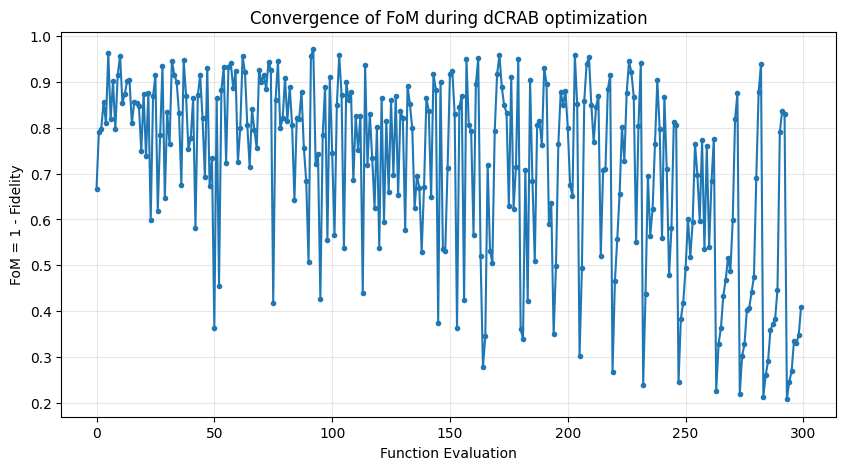

In [20]:
import numpy as np
import matplotlib.pyplot as plt


opt_alg = optimizer.get_optimization_algorithm()


fom_list = np.array(opt_alg.FoM_list)
N = len(fom_list)

plt.figure(figsize=(10,5))
plt.plot(fom_list, "-o", markersize=3)
plt.xlabel("Function Evaluation")
plt.ylabel("FoM = 1 - Fidelity")
plt.title("Convergence of FoM during dCRAB optimization")
plt.grid(alpha=0.3)
plt.show()


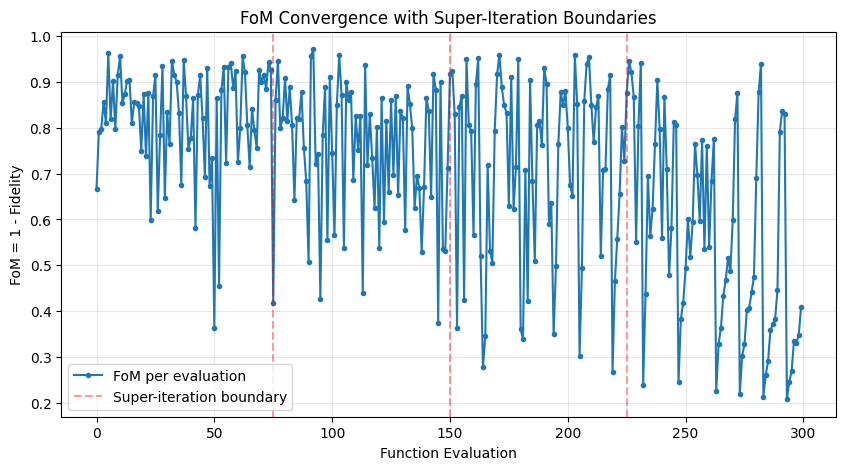

In [21]:

max_eval = optimizer.get_optimization_algorithm().max_eval_total
SI = opt_dict["algorithm_settings"]["super_iteration_number"]
evals_per_SI = max_eval // SI

plt.figure(figsize=(10,5))
plt.plot(fom_list, "-o", markersize=3, label="FoM per evaluation")
for k in range(1, SI):
    plt.axvline(k * evals_per_SI, color="red", linestyle="--", alpha=0.4,
                label="Super-iteration boundary" if k==1 else None)

plt.xlabel("Function Evaluation")
plt.ylabel("FoM = 1 - Fidelity")
plt.title("FoM Convergence with Super-Iteration Boundaries")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


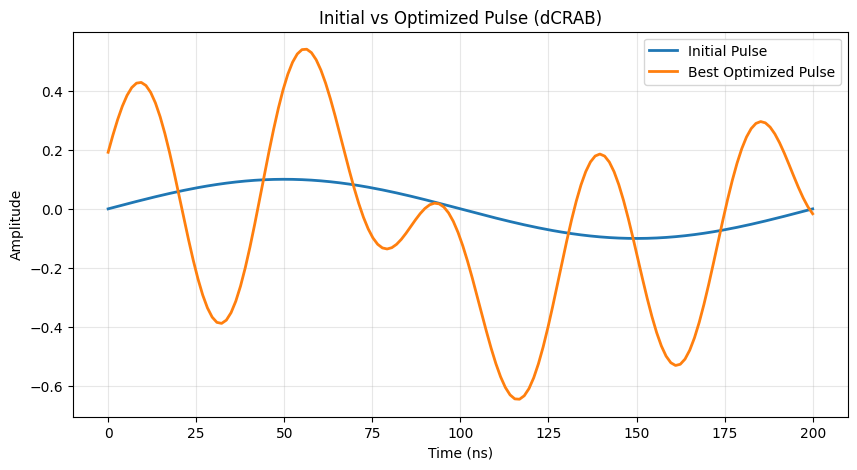

In [23]:
import numpy as np
import matplotlib.pyplot as plt


best_controls = opt_alg.get_best_controls()
best_pulse = np.array(best_controls["pulses"][0])
time_best = np.array(best_controls["timegrids"][0])


T = time_best[-1]
initial_pulse = 0.1 * np.sin(2 * np.pi * time_best / T)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(time_best, initial_pulse, label="Initial Pulse", linewidth=2)
plt.plot(time_best, best_pulse, label="Best Optimized Pulse", linewidth=2)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("Initial vs Optimized Pulse (dCRAB)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [24]:
opt_alg = optimizer.get_optimization_algorithm()
fom_list = np.array(opt_alg.FoM_list)
controls = opt_alg.get_best_controls()
best_pulse = np.array(controls["pulses"][0])
best_time = np.array(controls["timegrids"][0])
print("Total evals:", len(fom_list))
print("Best FoM:", np.min(fom_list), "=> Best fidelity:", 1.0 - np.min(fom_list))


Total evals: 300
Best FoM: 0.20730679321080114 => Best fidelity: 0.7926932067891989


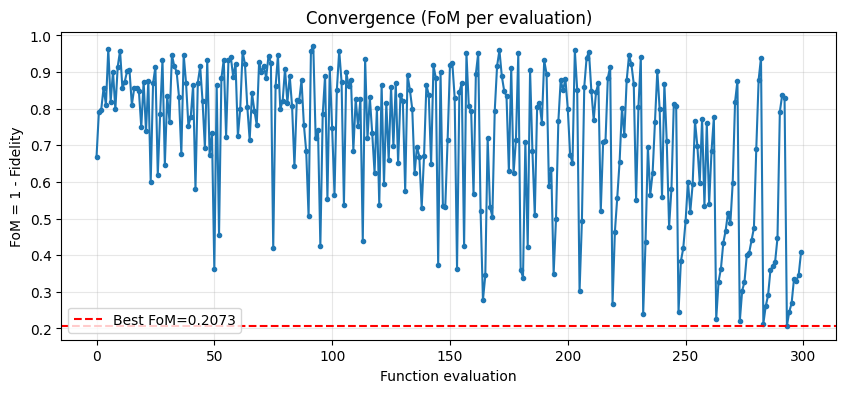

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(fom_list, '-o', markersize=3)
plt.axhline(np.min(fom_list), color='red', linestyle='--', label=f"Best FoM={np.min(fom_list):.4f}")
plt.xlabel("Function evaluation")
plt.ylabel("FoM = 1 - Fidelity")
plt.title("Convergence (FoM per evaluation)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


opt_alg = optimizer.get_optimization_algorithm()


fom_list = np.array(opt_alg.FoM_list)
N = len(fom_list)


df = pd.DataFrame({
    "evaluation": np.arange(N),
    "FoM": fom_list
})


window = 7
df["FoM_smooth"] = df["FoM"].rolling(window, center=True).mean()


display(df)


df.to_csv("fom_data.csv", index=False)
print("CSV saved as fom_data.csv")


,evaluation,FoM,FoM_smooth
0,0,0.667092,NaN
1,1,0.790307,NaN
2,2,0.797256,NaN
3,3,0.856714,0.814868
4,4,0.811019,0.848341
...,...,...,...
295,295,0.268942,0.366205
296,296,0.334968,0.305964
297,297,0.330250,NaN
298,298,0.346554,NaN


CSV saved as fom_data.csv
